In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Lets make a little toy model

In [2]:
def match_surrogates0(theta, intrinsic_noise, Groups=4, f=0):
    ## Different split approach
    from sklearn.cluster import AgglomerativeClustering
    # sorted_args = np.argsort(theta)
    # theta = theta[sorted_args]
    # intrinsic_noise=intrinsic_noise[sorted_args]
    clustering = AgglomerativeClustering(Groups).fit(theta.reshape(-1,1))
    labels = sorted(clustering.labels_)
    unique_ls, counts = np.unique(labels, return_counts=True)
    theta_R = np.concatenate([[np.mean(theta[labels==i])]*c for i, c in zip(unique_ls, counts)])
    noises = np.concatenate([intrinsic_noise[labels==i] for i, c in zip(unique_ls, counts)])
    surrogate_raw = get_Q(theta_R)
    surrogate_data = surrogate_raw + noises#*(1-f) + f*np.random.normal(0, sigma_epsilon, len(theta_R)) 
    return theta_R, surrogate_data, surrogate_raw

In [3]:
def match_surrogates0(theta_Q, intrinsic_noise, Groups, f=0):
    Surrogate_locs = np.linspace(-8.2, 8.2, Groups, endpoint=True)
    nearest_island = np.zeros_like(theta_Q)
    for i, pi in enumerate(theta_Q):
        # nearest_island[i] = self.Surrogate_locs[np.argmin(np.sum((pi[:-1] - self.Surrogate_locs[:, :-1])**2, axis=1))] # TODO: find a way to remove last axis for mass etc. 
        nearest_island[i] = Surrogate_locs[np.argmin((pi - Surrogate_locs)**2)] # TODO: find a way to remove last axis for mass etc. 
    R_raw = get_Q(nearest_island)
    R = R_raw + intrinsic_noise*(1-f) + f*np.random.normal(0, sigma_epsilon, len(R_raw))
    return nearest_island, R, R_raw

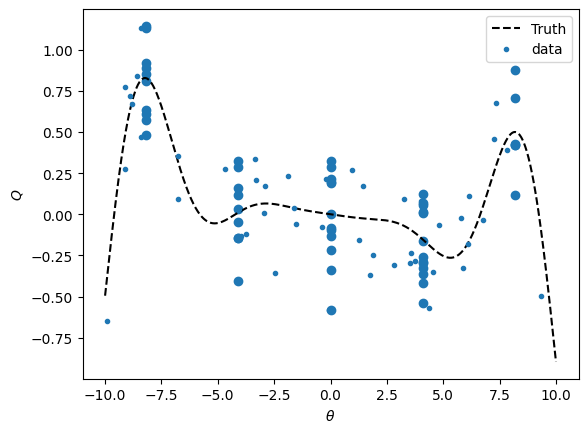

In [133]:
sigma_epsilon = 0.2 # jitter ontop of smooth variation
N=50          # Number of data samples
Domain = [-10,10] # Domain of parameters
LR = 3e-3         # Optimization learning rate 
ITERS = 3000      # max iteration
epsilon = 0.0     # Difference in smoothness from surrogates to high res
# Toy Models
def get_Q(theta, A=-0.4, B=0.4):
    """
    This is the model which we ultimitely want to predict, represents the 
    smooth variation on some function. 
    """
    return (A * theta  +  theta**3*B**4 * np.sin(theta))/20 #+ C * x * theta + D * x

def get_R(theta, epsilon=epsilon, A=-0.4, B=0.4):
    """
    If Surrogates have some different mean function then you can make that 
    here. For simulations of same "resolution" this should return the same
    as Q
    """
    Q = get_Q(theta, A, B)
    delta = epsilon * theta  + epsilon*1/(theta**2+ epsilon)
    return Q + delta

# underlying truth: 
theta=np.linspace(*np.array(Domain)+0.001, 1001, endpoint=True)
Y = get_Q(theta) 
plt.plot(theta, Y, 'k--', label='Truth')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$T$')

# Sample Data
np.random.seed(194)
theta_Q = np.linspace(Domain[0], Domain[1], N, )
theta_Q = np.random.uniform(Domain[0], Domain[1], N)
a = np.argsort(theta_Q)
theta_Q=theta_Q[a]
Q_raw = get_Q(theta_Q)

def model_data(theta, noise=None):
    Q = get_Q(theta)
    if noise is not None:
        return Q + noise
    noise = np.random.normal(0, sigma_epsilon, len(theta))
    return Q+noise, noise


# Sample Data
np.random.seed(194)
theta_Q2 = np.random.uniform(Domain[0], Domain[1], 2*N)
a2 = np.argsort(theta_Q2)
theta_Q2=theta_Q2[a2]
Q2_raw = get_Q(theta_Q2)
noise2 = np.random.normal(0, sigma_epsilon,2*N)
Q2 = Q2_raw + noise2



np.random.seed(30)
intrinsic_noise = np.random.normal(0, sigma_epsilon,N)
Q = Q_raw  + intrinsic_noise
# intrinsic_noise = Q - Q_raw
# intrinsic_noise2 = Q2 - Q2_raw


plt.plot(theta_Q, Q, '.', label='data')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$Q$')
plt.legend()

div = 2
N_R = int(N/div)
f=0.00

theta_R, R, E = match_surrogates0(theta_Q, intrinsic_noise,Groups=5, f=0)

plt.scatter(theta_R, R)


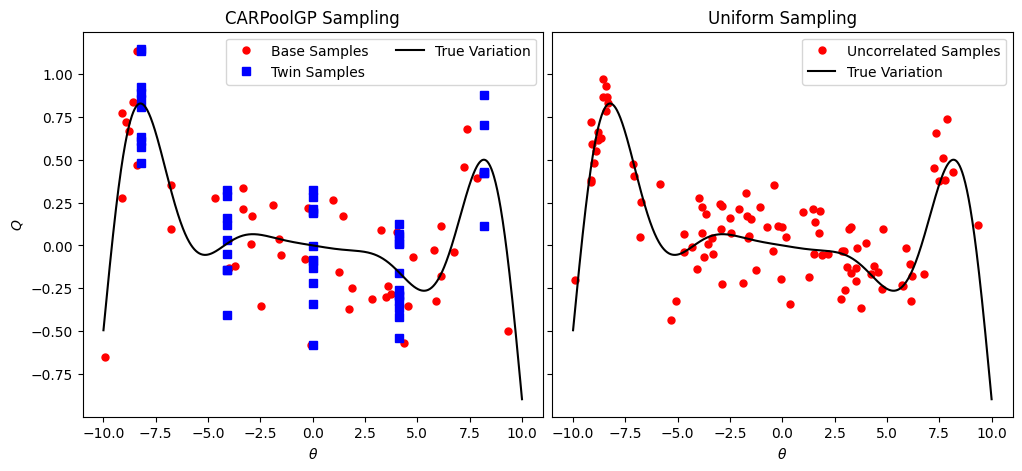

In [134]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12,5), gridspec_kw={'wspace':0.02})
axs[0].plot(theta_Q, Q, 'o', color='r', markersize=5, label='Base Samples')
axs[0].plot(theta_R, R, 's', color='b', label='Twin Samples')
axs[0].plot(theta, Y, 'k', label='True Variation')
axs[0].set_title('CARPoolGP Sampling')
axs[0].set_xlabel(r'$\theta$')
axs[0].set_ylabel('$Q$')



axs[1].plot(theta_Q2, Q2, 'o', color='r', markersize=5, label='Uncorrelated Samples')
axs[1].plot(theta, Y, 'k', label='True Variation')
axs[1].set_title('Uniform Sampling')
axs[1].set_xlabel(r'$\theta$')
axs[0].legend(ncol=2)
axs[1].legend()
plt.savefig('Img/CPsamplingVsUniform.pdf')


In [135]:
params = {"log_scaleV":0.0,
          "log_ampV":0.0,
          "log_scaleW":0.0,
          "log_ampW":0.0,
          "log_scaleX":0.0,
          "log_ampX":-5.0,                
          "log_scaleM":0.0,
          "log_deltaP":-0.0,
          "log_jitterV":-3.0,
          "log_jitterW":-3.0,
          "log_mean":0.0}

# Now we can use CARPoolGP

In [136]:
from src import CARPoolSimulations

# Create simulation objects and surrogate objects
sims = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters = theta_Q; sims.quantities=Q
surrs.parameters = theta_R; surrs.quantities=R

In [145]:
from src import CARPoolEmulator

#Build an emulator 
emu = CARPoolEmulator.Emulator(sims, surrs)

#Initialize some set of parameters (or default)
# params = {"log_scaleV":0.0,
#           "log_ampV":-1.0,
#           "log_scaleW":-1.0,
#           "log_ampW":0.0,
#           "log_scaleX":0.0,
#           "log_ampX":-2.0,                
#           "log_scaleM":0.0,
#           "log_deltaP":-1.0,
#           "log_jitterV":-2.0,
#           "log_jitterW":-2.0,
#           "log_mean":0.0}

# Train the emulator
best_params = emu.train(params, learning_rate=1e-5, max_iterations=5000)

# now emulate! 
pred_mean, pred_var = emu.predict(theta)

Text(0.5, 0, 'Iters')

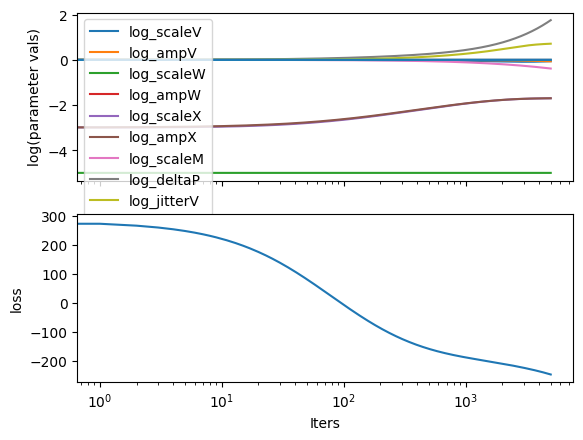

In [146]:
fig, axs = plt.subplots(nrows=2, sharex=True)
ps_i = [[list(p.values())[i] for i in range(len(params.keys()))] for p in emu.param_evolution]
axs[1].semilogx(emu.losses[0])
for i in range(len(params.keys())):
    axs[0].semilogx(np.array(ps_i)[:, i], label=list(params.keys())[i])

axs[0].legend()
axs[0].set_ylabel('log(parameter vals)')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('Iters')

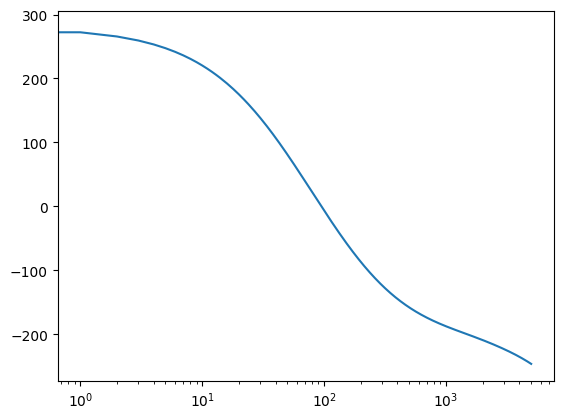

In [147]:
plt.semilogx(emu.losses[0])

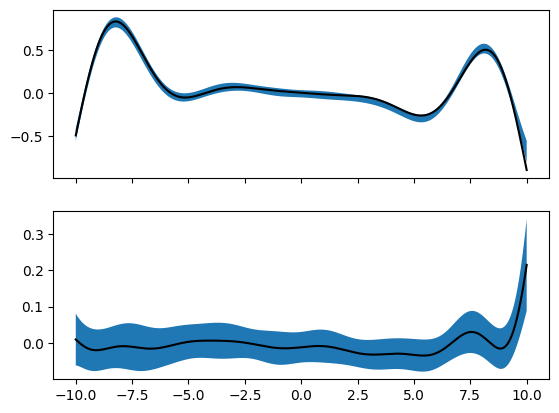

In [153]:
fig, axs = plt.subplots(nrows=2, sharex=True)
std = np.sqrt(np.diag(pred_var))
axs[0].fill_between(theta, pred_mean - std, pred_mean+std)
axs[0].plot(theta, Y, 'k')

axs[1].fill_between(theta, (pred_mean-Y) - std, (pred_mean-Y)+std)
axs[1].plot(theta, (pred_mean - Y), 'k')


In [142]:
from src import CARPoolSimulations

# Create simulation objects and surrogate objects
sims2 = CARPoolSimulations.Simulation()
surrs2 = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims2.parameters = theta_Q2[::2]; sims2.quantities=Q2[::2]
surrs2.parameters = theta_Q2[1::2]; surrs2.quantities=Q2[1::2]

In [143]:
from src import CARPoolEmulator

#Build an emulator 
emu2 = CARPoolEmulator.Emulator(sims2, surrs2)

# Train the emulator
best_params2 = emu2.train(params, learning_rate=1e-5, max_iterations=5000)

# now emulate! 
pred_mean2, pred_var2 = emu2.predict(theta)

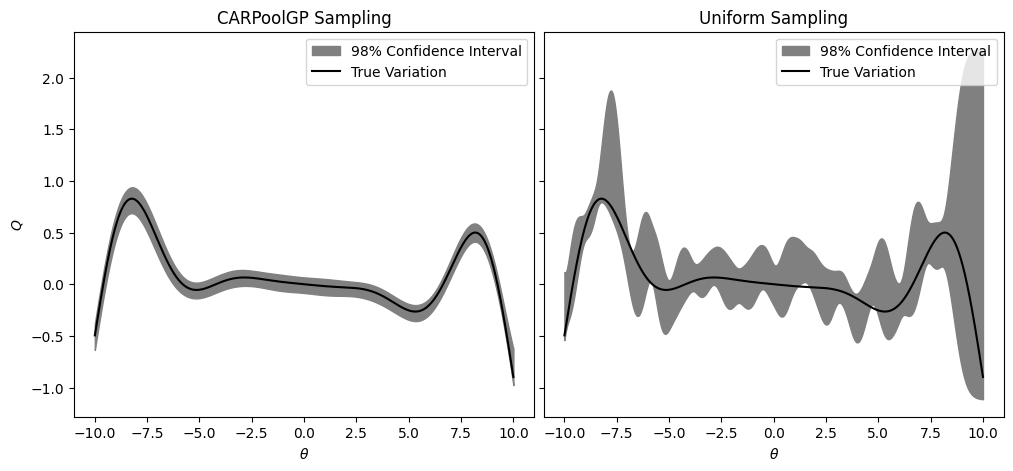

In [144]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5), sharex=True, sharey=True, gridspec_kw={'wspace':0.02})


std = np.sqrt(np.diag(pred_var))
axs[0].fill_between(theta, pred_mean - 2*std, pred_mean+2*std, color='grey', label='98% Confidence Interval')
axs[0].plot(theta, Y, 'k', label='True Variation')

std = np.sqrt(np.diag(pred_var2))
axs[1].fill_between(theta, pred_mean2 - 2*std, pred_mean2+2*std, color='grey',label='98% Confidence Interval')
axs[1].plot(theta, Y, 'k', label='True Variation')

axs[1].set_title('Uniform Sampling')
axs[1].set_xlabel(r'$\theta$')

axs[0].set_title('CARPoolGP Sampling')
axs[0].set_xlabel(r'$\theta$')
axs[0].set_ylabel('$Q$')
axs[0].legend()
axs[1].legend()
plt.savefig('Img/CarpoolVsUniform_fits.pdf')

In [112]:
from src import CARPoolProcess

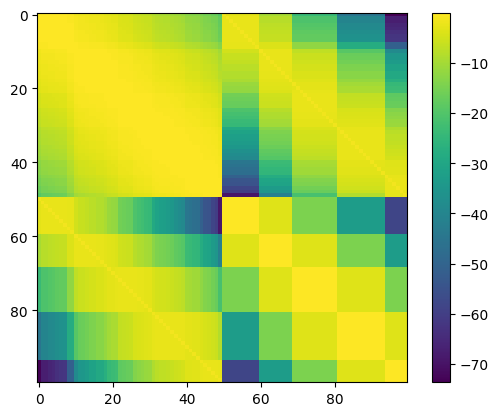

In [124]:
plt.imshow(np.log10(CARPoolProcess.build_CARPoolCov(best_params, sims.parameters, surrs.parameters)))
plt.colorbar()

# Active learning approach

In [126]:
from src import CARPoolEmulator

# Generate an active learning model
model = CARPoolEmulator.ActiveLearning(sims, surrs, theta, Domain[0], Domain[1])

# Initialize the training
best_params = model.train(params, learning_rate=1e-5, max_iterations=5000)

In [127]:
# Run an active learning step to find the next state (Ngrid is for 2**N)
next_thetas, next_surrogates = model.active_learning_step(num_new=10, Ngrid=7, normalize=False)

In practice we would now run simulations at these new points, but lets say we have a model that is the simulation. then we can update the simulations and re train

In [129]:
# Generate new data
next_noise = np.random.normal(0, sigma_epsilon, len(next_thetas))
next_data           = get_Q(next_thetas.flatten()) + next_noise
next_surrogate_data = get_Q(next_surrogates.flatten()) + next_noise

In [130]:
# update the parameters and data
model.Simulations.update(next_thetas, next_data)
model.Surrogates.update(next_surrogates, next_surrogate_data)

In [131]:
# Retrain the model
best_params = model.train(params, learning_rate=1e-5, max_iterations=5000)

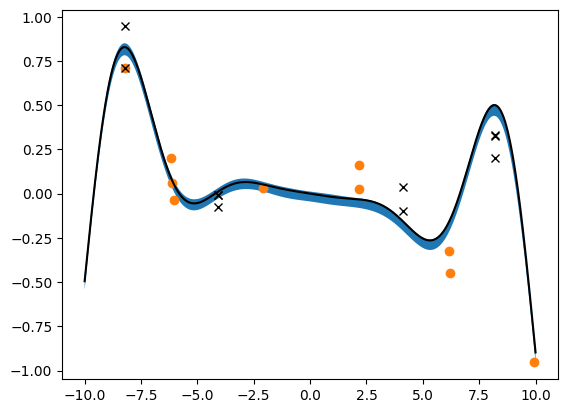

In [132]:
# Predict the test points
pred_mean, pred_var = model.predict(theta)
std = np.sqrt(np.diag(pred_var))
plt.fill_between(theta, pred_mean - std, pred_mean+std)
plt.plot(theta, Y, 'k')
plt.scatter(next_thetas, next_data)
plt.plot(next_surrogates, next_surrogate_data, 'kx')



Now we can perform the above iteratively! 

In [401]:
from src import CARPoolEmulator
Means = []
Vars = []
Niters = 5

# Generate an active learning model
model = CARPoolEmulator.ActiveLearning(sims, surrs, theta, Domain[0], Domain[1])

# Initialize the training
best_params = model.train(params, learning_rate=1e-5, max_iterations=5000)

for i in range(Niters):
    # Run an active learning step to find the next state (Ngrid is for 2**N)
    next_thetas, next_surrogates = model.active_learning_step(num_new=10, Ngrid=7, normalize=False)
    
    # Generate new data
    next_noise = np.random.normal(0, sigma_epsilon, len(next_thetas))
    next_data           = get_Q(next_thetas.flatten()) + next_noise
    next_surrogate_data = get_Q(next_surrogates.flatten()) + next_noise
    
    # update the parameters and data
    model.Simulations.update(next_thetas, next_data)
    model.Surrogates.update(next_surrogates, next_surrogate_data)

    # Retrain the model
    best_params = model.train(params, learning_rate=1e-5, max_iterations=5000)
    # Predict the test points
    pred_mean, pred_var = model.predict(theta)
    
    Means.append(pred_mean)
    Vars.append(pred_var)
    print(next_thetas.flatten())

[-5.60907619  9.88363275 -7.63918221  8.7796125  -5.64151544  2.53631428
 -5.16565684 -7.43312225  9.9272996  -9.99936381]
[ 8.89027821 -6.29585499 -1.03684112  0.73294487 -4.7313313   5.07571565
  8.05868769 -6.16928691 -7.60886833  2.5621618 ]
[-1.09205667  9.12708454  6.98547952  9.9991744  -9.91169481 -2.33671516
  0.71133202 -4.5517496   5.23680024 -6.09989895]
[-7.46533059  2.6232969   8.06865402 -0.8373134   6.2616523  -2.61077408
  9.01843239  0.88274634  4.49675266 -4.4401646 ]
[-6.21659851  2.66420498 -7.68425917 -0.88554425  7.32577575 -9.68856202
  6.25035759 -1.97651245 -5.25326017  0.85633187]


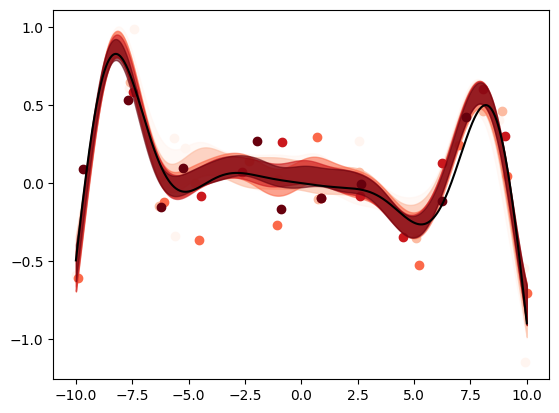

In [402]:
cs = plt.cm.Reds(np.linspace(0, 1, Niters))
for i in range(Niters):
    std = np.sqrt(np.diag(Vars[i]))
    plt.fill_between(theta, Means[i] - std, Means[i]+std, color=cs[i], alpha=0.6)
    plt.scatter(model.Simulations.parameters[50 + i*10: 50 + (i+1)*10], model.Simulations.quantities[50 + i*10: 50 + (i+1)*10], c=cs[i])
plt.plot(theta, Y, 'k')


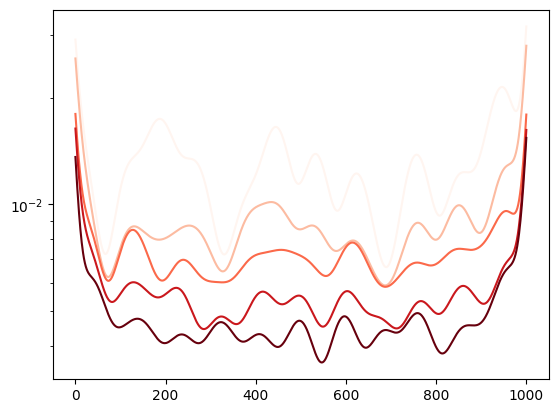

In [403]:
for i in range(5):
    plt.semilogy(np.diag(Vars[i]), c=cs[i])

Comparing with an equivalent network that contains all random samples

In [270]:
# Sample Data
np.random.seed(194)
theta_Q2 = np.random.uniform(Domain[0], Domain[1], 4*N)
a2 = np.argsort(theta_Q2)
theta_Q2=theta_Q2[a2]
Q2_raw = get_Q(theta_Q2)
noise = np.random.normal(0, sigma_epsilon,4*N)
Q2 = Q2_raw + noise

In [379]:
from src import CARPoolSimulations

# Create simulation objects and surrogate objects
sims = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters = theta_Q2[::2]; sims.quantities=Q2[::2]
surrs.parameters = theta_Q2[1::2]; surrs.quantities=Q2[1::2]

In [390]:
from src import CARPoolEmulator

#Build an emulator 
emu2 = CARPoolEmulator.Emulator(sims, surrs)

#Initialize some set of parameters (or default)
params = {"log_scaleV":0.0,
          "log_ampV":0.0,
          "log_scaleW":0.0,
          "log_ampW":0.0,
          "log_scaleX":0.0,
          "log_ampX":-5.0,                
          "log_scaleM":0.0,
          "log_deltaP":-20.0,
          "log_jitterV":-3.0,
          "log_jitterW":-3.0,
          "log_mean":0.0}

# Train the emulator
best_params2 = emu2.train(params, learning_rate=1e-5, max_iterations=5000)

# now emulate! 
pred_mean2, pred_var2 = emu2.predict(theta)

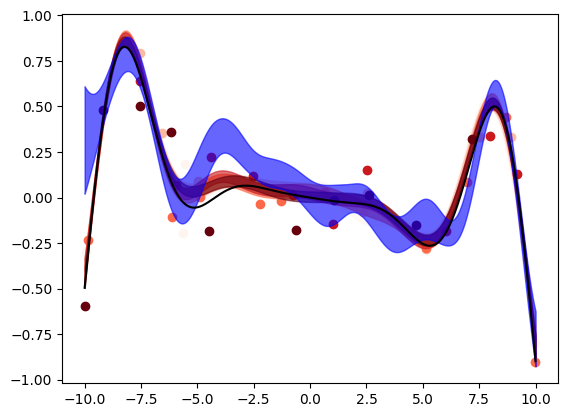

In [391]:
cs = plt.cm.Reds(np.linspace(0, 1, Niters))
for i in range(Niters):
    std = np.sqrt(np.diag(Vars[i]))
    plt.fill_between(theta, Means[i] - std, Means[i]+std, color=cs[i], alpha=0.6)
    plt.scatter(model.Simulations.parameters[50 + i*10: 50 + (i+1)*10], model.Simulations.quantities[50 + i*10: 50 + (i+1)*10], c=cs[i])
plt.plot(theta, Y, 'k')
std = np.sqrt(np.diag(pred_var2))
plt.fill_between(theta, pred_mean2 - std, pred_mean2+std, color='b', alpha=0.6)


In [ ]:
np.linspace(1e-3, 0.2, 10),

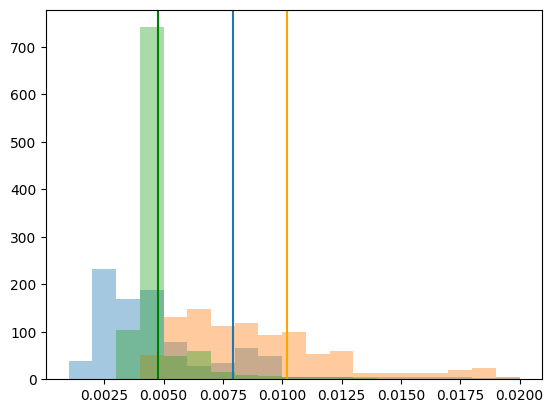

In [416]:
# for i in range(5):
plt.hist(np.diag(pred_var), bins=np.linspace(1e-3, 0.02, 20), alpha=0.4)
plt.axvline(np.mean(np.diag(pred_var)))
plt.hist(np.diag(pred_var2), bins=np.linspace(1e-3, 0.02, 20), alpha=0.4)
plt.axvline(np.mean(np.diag(pred_var2)), c='orange')
plt.hist(np.diag(Vars[-1]), bins=np.linspace(1e-3, 0.02, 20), alpha=0.4)
plt.axvline(np.mean(np.diag(Vars[-1])), color='green')



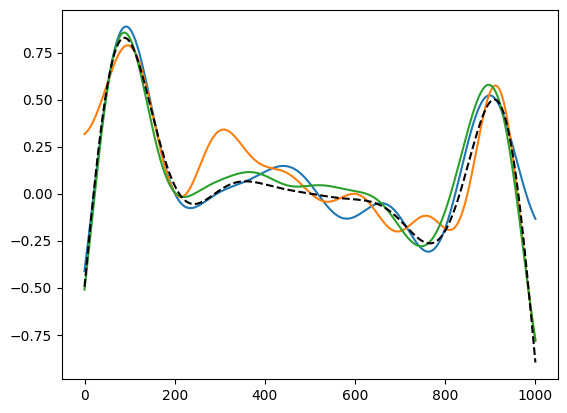

In [417]:
plt.plot(pred_mean)
plt.plot(pred_mean2)
plt.plot(Means[-1])

plt.plot(Y,'k--')

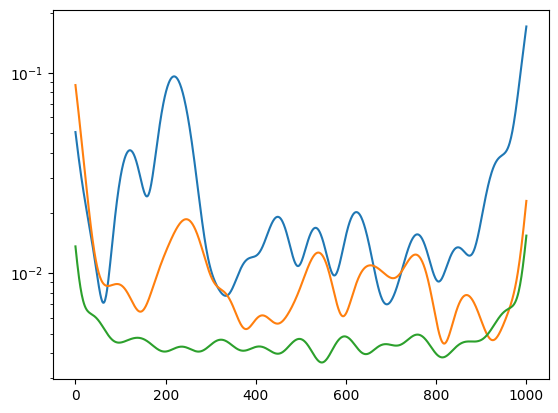

In [431]:
plt.plot(np.diag(pred_var))
plt.plot(np.diag(pred_var2))
plt.semilogy(np.diag(Vars[-1]))

In [420]:
np.sum(np.diag(pred_var)), np.sum(np.diag(pred_var2)), np.sum(np.diag(Vars[-1]))

(7.951396745954307, 10.229670423629297, 4.782368937088355)

In [296]:
best_params = model.train(params, learning_rate=1e-5, max_iterations=5000)


In [293]:
best_params2

{'log_ampV': DeviceArray(-0.15333194, dtype=float64),
 'log_ampW': DeviceArray(-0.08116962, dtype=float64),
 'log_ampX': DeviceArray(-20., dtype=float64),
 'log_deltaP': DeviceArray(-20., dtype=float64),
 'log_jitterV': DeviceArray(-2.41204839, dtype=float64),
 'log_jitterW': DeviceArray(-2.37304647, dtype=float64),
 'log_mean': DeviceArray(-0.48531076, dtype=float64),
 'log_scaleM': DeviceArray(10., dtype=float64),
 'log_scaleV': DeviceArray(0.29365862, dtype=float64),
 'log_scaleW': DeviceArray(0.64060546, dtype=float64),
 'log_scaleX': DeviceArray(1.74445587e-08, dtype=float64)}

In [277]:
best_params

{'log_ampV': DeviceArray(-0.04256813, dtype=float64),
 'log_ampW': DeviceArray(-0.07612944, dtype=float64),
 'log_ampX': DeviceArray(-20., dtype=float64),
 'log_deltaP': DeviceArray(-6.09514837e-11, dtype=float64),
 'log_jitterV': DeviceArray(-2.14291696, dtype=float64),
 'log_jitterW': DeviceArray(-2.18069431, dtype=float64),
 'log_mean': DeviceArray(-0.38184817, dtype=float64),
 'log_scaleM': DeviceArray(10., dtype=float64),
 'log_scaleV': DeviceArray(0.67265806, dtype=float64),
 'log_scaleW': DeviceArray(0.00037239, dtype=float64),
 'log_scaleX': DeviceArray(-8.09918774e-13, dtype=float64)}

In [283]:
np.exp(0.00037239)**2, np.exp(0.64060546)**2

(1.0007450574174916, 3.6009976065358704)

In [287]:
np.exp(10)**2

485165195.40979034